# Sawppy Ackermann Math
This Jupyter notebook works through the process of calculating the angle and velocity for every Sawppy wheel in response to a command to move the entire rover at a particular angular and linear velocity.

##  Setup
Sawppy chassis is represented by a list of six wheels, each listing a human-readable name and the X,Y coordinates relative to rover's center of motion.

In [1]:
# Sawppy chassis geometry (in meters)
SAWPPY_WHEELBASE_FRONT = 0.285
SAWPPY_WHEELBASE_MID = 0
SAWPPY_WHEELBASE_REAR = -0.257
SAWPPY_TRACK_FRONT = 0.23
SAWPPY_TRACK_MID = 0.26
SAWPPY_TRACK_REAR = 0.23

In [2]:
class ChassisWheel(object):
    """Information needed to calculate angle and speed for a specific wheel.
    Axis orientation conforms to REP103. (+X is forward, +Y is left, +Z is up)
    https://www.ros.org/reps/rep-0103.html
    """

    def __init__(self, name, offset_front, offset_left):
        """Initialize a chassis wheel instance with X & Y relative to center.
        Args:
            name : name for this wheel
            offset_front : front/back relative to center, positive forward.
            offset_left : left/right relative to center, positive left.
        """
        self.name = name
        self.offset_front = offset_front
        self.offset_left = offset_left

In [3]:
class ChassisWheelAngleSpeed(object):
    """Results of chassis geometry calculation for the named wheel."""

    def __init__(self, name, angle, velocity):
        """Initialize a chassis wheel with desired angle and velocity.
        Args:
            name : name for this wheel
            angle : steering angle for this wheel in radians.
            velocity : rolling velocity for this wheel in meters/second
        """
        self.name = name
        self.angle = angle
        self.velocity = velocity

In [4]:
test_chassis = []
test_chassis.append(
    ChassisWheel(
        'front_left',  SAWPPY_WHEELBASE_FRONT,  SAWPPY_TRACK_FRONT,
        ),
    )
test_chassis.append(
    ChassisWheel(
        'front_right', SAWPPY_WHEELBASE_FRONT, -SAWPPY_TRACK_FRONT,
        ),
    )
test_chassis.append(
    ChassisWheel(
        'mid_left',      SAWPPY_WHEELBASE_MID,  SAWPPY_TRACK_MID,
        ),
    )
test_chassis.append(
    ChassisWheel(
        'mid_right',     SAWPPY_WHEELBASE_MID, -SAWPPY_TRACK_MID,
        ),
    )
test_chassis.append(
    ChassisWheel(
        'rear_left',    SAWPPY_WHEELBASE_REAR,  SAWPPY_TRACK_REAR,
        ),
    )
test_chassis.append(
    ChassisWheel(
        'rear_right',   SAWPPY_WHEELBASE_REAR, -SAWPPY_TRACK_REAR,
        ),
    )
        

## Input

In [51]:
import math

# Commanded inputs
velocityAngular = -0.2*math.pi # radians/sec
velocityLinear = 0 # meters/sec

## Calculation

### Center of turn

Consider the state of the robot after one second of traveling at commanded `velocityAngular` and `velocityLinear`. It would be pointing at `velocityAngular` radians off of +X axis (marking forward) and have covered `velocityLinear` distance. This describes an arc. Where is the center of the arc?

One way to think about this problem is to consider the case where angular velocity is `2*pi`. After one second, the robot has traveled in a complete circle and `velocityLinear` is the circumference of that circle. Distance to the center of this circle would therefore be the radius, or `velocityLinear/2*pi`

This formula holds for other values of `velocityAngular`. The linear distance traveled is some fraction of a circle, and dividing by the angular velocity returns the center of that circle.

If `velocityAngular` is zero, we are traveling straight forward which is mathematically equivalent to a circle with infinite radius. This is set as our default value.

In [52]:
turnCenter = math.inf
if velocityAngular != 0:
    turnCenter = velocityLinear / velocityAngular
print(turnCenter)

-0.0


### Wheel Angle and Velocity
Once the center of turn has been calculated, we can calculate the angle and distance from that point to each wheel.
The angle becomes the [Ackermann steering angle](https://en.wikipedia.org/wiki/Ackermann_steering_geometry) for that wheel.
The distance is compared with the center of turn, and the ratio determines velocity for that wheel.

In [53]:
calculated_results = []
for wheel in test_chassis:
    if turnCenter == math.inf:
        # Heading directly forward or back
        wheel_angle = 0
        wheel_velocity = velocityLinear
    else:
        # Dimensions of a trialge representing the wheel relative to center of turn.
        opposite = wheel.offset_front
        adjacent = turnCenter - wheel.offset_left
        hypotenuse = math.sqrt(pow(opposite,2)+pow(adjacent,2))
        if wheel.offset_front == 0:
            wheel_angle = 0
        else:
            wheel_angle = math.atan(opposite / adjacent)
        if velocityLinear == 0:
            wheel_velocity = velocityAngular * hypotenuse
        else:
            wheel_velocity = math.copysign(velocityAngular * hypotenuse, velocityLinear)
        # If center of turn is inside the wheel, we need to reverse direction.
        if (turnCenter >= 0 and wheel.offset_left > 0 and wheel.offset_left > turnCenter) or \
           (turnCenter < 0 and wheel.offset_left < 0 and wheel.offset_left < turnCenter):
            wheel_velocity = wheel_velocity * -1
    calculated_results.append(ChassisWheelAngleSpeed(wheel.name, wheel_angle, wheel_velocity))

(-0.4, 0.4, -0.4, 0.4)

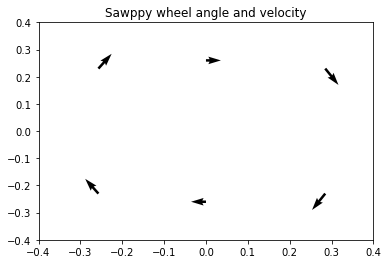

In [54]:
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

plot_x = []
plot_y = []
plot_u = []
plot_v = []
wheel_state = dict()

for wheel in test_chassis:
    wheel_state[wheel.name] = dict()
    wheel_state[wheel.name]['x'] = wheel.offset_front
    wheel_state[wheel.name]['y'] = wheel.offset_left
    wheel_state[wheel.name]['hypotenuse'] = math.sqrt(pow(wheel.offset_front,2)+pow(wheel.offset_left,2))
for wheel in calculated_results:
    plot_x.append(wheel_state[wheel.name]['x'])
    plot_y.append(wheel_state[wheel.name]['y'])
    wheel_state[wheel.name]['angle'] = wheel.angle
    wheel_state[wheel.name]['velocity'] = wheel.velocity
    plot_u.append(math.cos(wheel.angle)*wheel.velocity)
    plot_v.append(math.sin(wheel.angle)*wheel.velocity)

fig, ax = plt.subplots()
ax.set_title('Sawppy wheel angle and velocity')
ax.quiver(plot_x, plot_y, plot_u, plot_v)
ax.axis([-0.4, 0.4, -0.4, 0.4])

Print the input and output of this particular scenario in a format suitable for the unit test data file `chassis_wheel_calculator_tests.csv`

In [9]:
print('{: .6f},{: .6f},{: .6f},{: .6f},{: .6f},{: .6f},{: .6f},{: .6f},{: .6f},{: .6f},{: .6f},{: .6f},{: .6f},{: .6f}'.format(
velocityAngular, velocityLinear,
wheel_state['front_left']['angle'],
wheel_state['front_left']['velocity'],
wheel_state['front_right']['angle'],
wheel_state['front_right']['velocity'],
wheel_state['mid_left']['angle'],
wheel_state['mid_left']['velocity'],
wheel_state['mid_right']['angle'],
wheel_state['mid_right']['velocity'],
wheel_state['rear_left']['angle'],
wheel_state['rear_left']['velocity'],
wheel_state['rear_right']['angle'],
wheel_state['rear_right']['velocity']))

-0.314159, 0.100000,-0.479345, 0.194136,-1.270319, 0.093735, 0.000000, 0.181681, 0.000000, 0.018319, 0.438306, 0.190240, 1.239818, 0.085373
